In [1]:
### IMPORT BIBLIOTECAS

import requests
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn  as sns
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import folium
import json
from tqdm.auto import tqdm
from datetime import datetime

C:\Users\Matheus\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv('data-extraction-and-transform/flights_brazil_2019.csv', compression = 'gzip')
data.head()

C:\Users\Matheus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,nr_voo,empresa_aerea,cd_tipo_linha,cidade_origem,cidade_destino,pais_origem,pais_destino,dt_partida_prevista,dt_partida_real,dt_chegada_prevista,...,dia_semana,mes,ano,atraso_chegada_min,atraso_partida_min,latitude_origem,latitude_destino,longitude_origem,longitude_destino,cd_di
0,35,NaN,Internacional,PARIS,CAMPINAS,FRANCA,BRASIL,2019-01-25 06:15:00,2019-01-25 06:15:00,2019-01-25 18:15:00,...,6 - Sexta,01 - Janeiro,2019.0,0.0,0.0,48.723333,-23.007401,2.379444,-47.134499,0
1,35,NaN,Internacional,PARIS,CAMPINAS,FRANCA,BRASIL,2019-01-27 06:15:00,2019-01-27 06:15:00,2019-01-27 18:15:00,...,1 - Domingo,01 - Janeiro,2019.0,0.0,0.0,48.723333,-23.007401,2.379444,-47.134499,0
2,35,NaN,Internacional,PARIS,CAMPINAS,FRANCA,BRASIL,2019-01-29 06:15:00,2019-01-29 06:15:00,2019-01-29 18:15:00,...,3 - Terça,01 - Janeiro,2019.0,0.0,0.0,48.723333,-23.007401,2.379444,-47.134499,0
3,36,NaN,Internacional,CAMPINAS,PARIS,BRASIL,FRANCA,2019-01-25 20:15:00,2019-01-25 20:15:00,2019-01-26 07:45:00,...,6 - Sexta,01 - Janeiro,2019.0,0.0,0.0,-23.007401,48.723333,-47.134499,2.379444,0
4,36,NaN,Internacional,CAMPINAS,PARIS,BRASIL,FRANCA,2019-01-27 20:15:00,2019-01-27 20:15:00,2019-01-28 07:45:00,...,1 - Domingo,01 - Janeiro,2019.0,0.0,0.0,-23.007401,48.723333,-47.134499,2.379444,0


# divisao chegada/partida
## status voos no brasil
• cidade com mais voos

• voos por categoria

• dia da semana com mais voos

• dia do mes com mais voos

• voos por mes


## status atrasos de voos no brasil
• cidade com mais atrasos

• cidade com mais atrasos relativo %

• atraso medio por cidade

• atraso medio por mes da cidade com mais voo

• atraso voos nacionais e internacionais

• dia da semana com mais atrasos e atraso médio

• dia do mes com mais atrasos e atraso médio

• atrasos por mes

• minutos de atraso por mes


# Cidades com mais voos

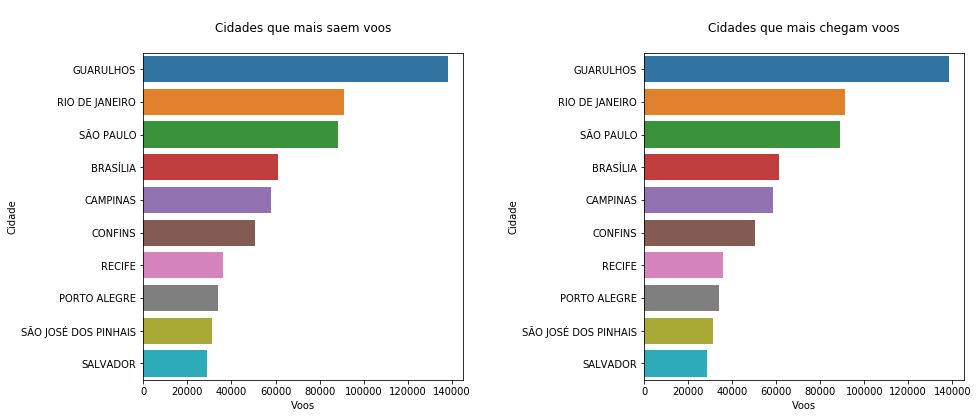

In [28]:
maissaivoo = data[['cidade_origem','dia']].groupby('cidade_origem').count().sort_values(by = 'dia', ascending = False).reset_index().head(10)
maischegavoo = data[['cidade_destino','dia']].groupby('cidade_destino').count().sort_values(by = 'dia', ascending = False).reset_index().head(10)

fig, ax = plt.subplots(1,2, figsize = (16, 9))
fig.tight_layout(pad = 15)

sns.barplot(y = 'cidade_origem', x = 'dia', data = maissaivoo, ax = ax[0])
ax[0].set_xlabel('Voos')
ax[0].set_ylabel('Cidade')
ax[0].set_title('\nCidades que mais saem voos\n')

sns.barplot(y = 'cidade_destino', x ='dia', data = maischegavoo, ax = ax[1])
ax[1].set_xlabel('Voos')
ax[1].set_ylabel('Cidade')
ax[1].set_title('\nCidades que mais chegam voos\n');

# Voos por categoria

In [44]:
# data possui uma categoria errada ("E"), irá ser dropada para a análise
index = data[data['cd_tipo_linha'] == 'E'].index[0]

,cd_tipo_linha,dia
0,Nacional,814384
1,Internacional,143343
2,Cargueiro internacional,17987
3,Cargueiro,6716
4,Rede postal,502
5,Regional,43


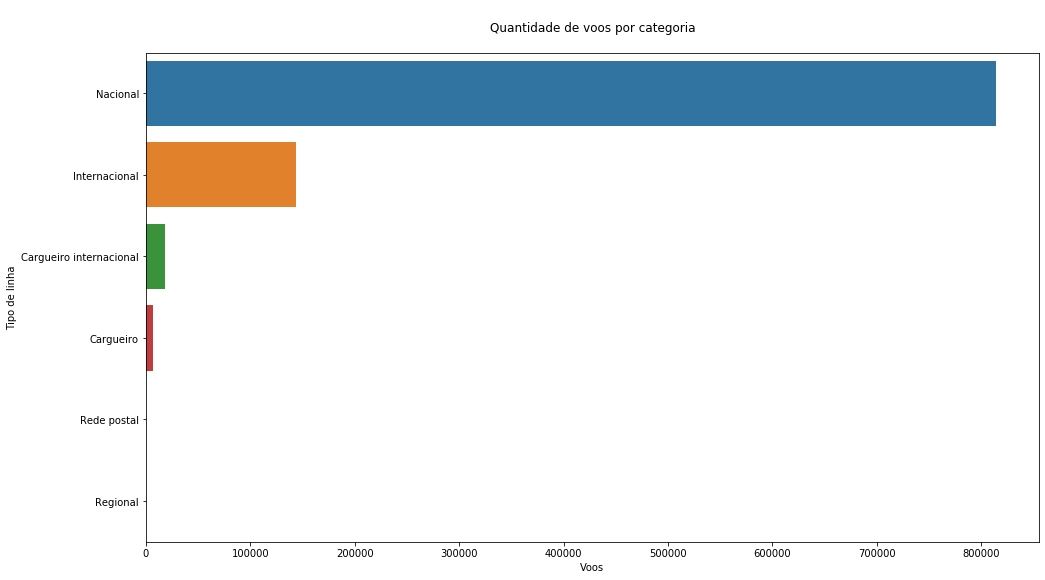

In [49]:
conttipo = data.drop(index)[['cd_tipo_linha','dia']].groupby('cd_tipo_linha').count().sort_values(by = 'dia', ascending = False).reset_index()

fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(y = 'cd_tipo_linha', x = 'dia', data = conttipo, ax = ax)
ax.set_xlabel('Voos')
ax.set_ylabel('Tipo de linha')
ax.set_title('\nQuantidade de voos por categoria\n');

# neste caso será mostrado o display da tabela com intuíto de mostrar que os valroes
# de 'rede postal' e 'regional' não são zero
display(conttipo)

# Dia da semana com mais voos

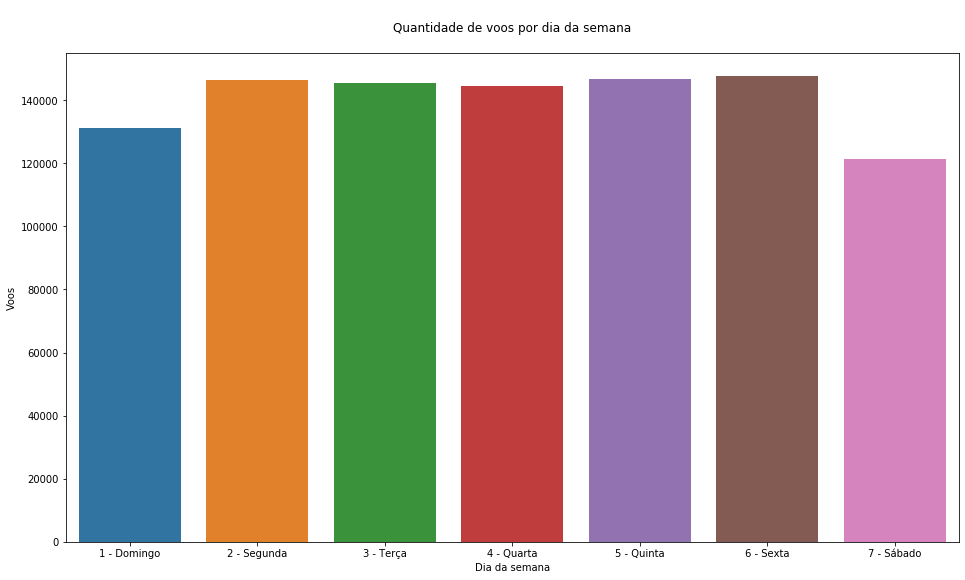

In [53]:
partida = data[['dia_semana','dia']].groupby('dia_semana').count().reset_index()

fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(x = 'dia_semana', y = 'dia', data = partida, ax = ax)
ax.set_xlabel('Dia da semana')
ax.set_ylabel('Voos')
ax.set_title('\nQuantidade de voos por dia da semana\n');


# Dia do mes com mais voos

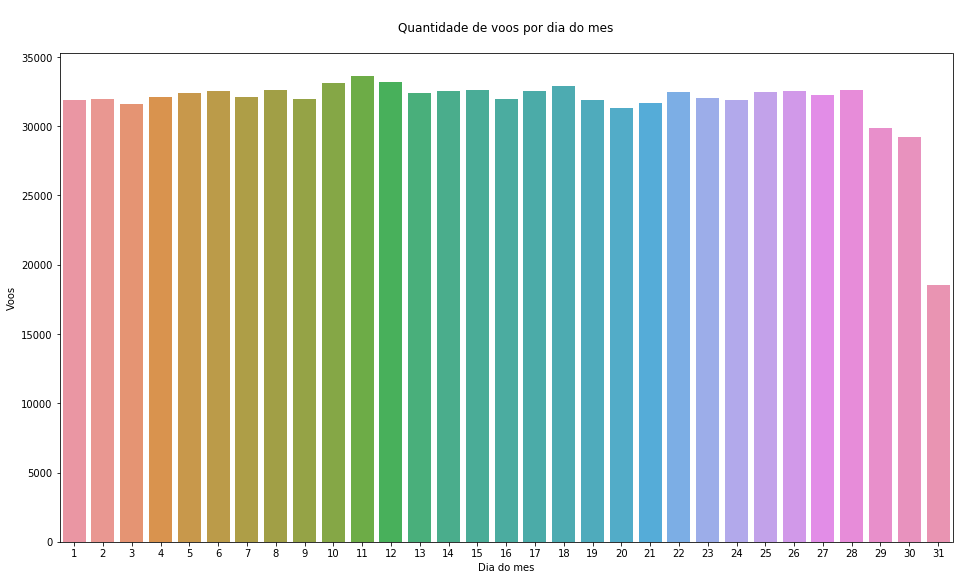

In [59]:
partida = data[['dia','mes']].groupby('dia').count().reset_index()
partida['dia'] = partida['dia'].astype('int64')
fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(x = 'dia', y = 'mes', data = partida, ax = ax)
ax.set_xlabel('Dia do mes')
ax.set_ylabel('Voos')
ax.set_title('\nQuantidade de voos por dia do mes\n');

# Quantidade de voos por mes

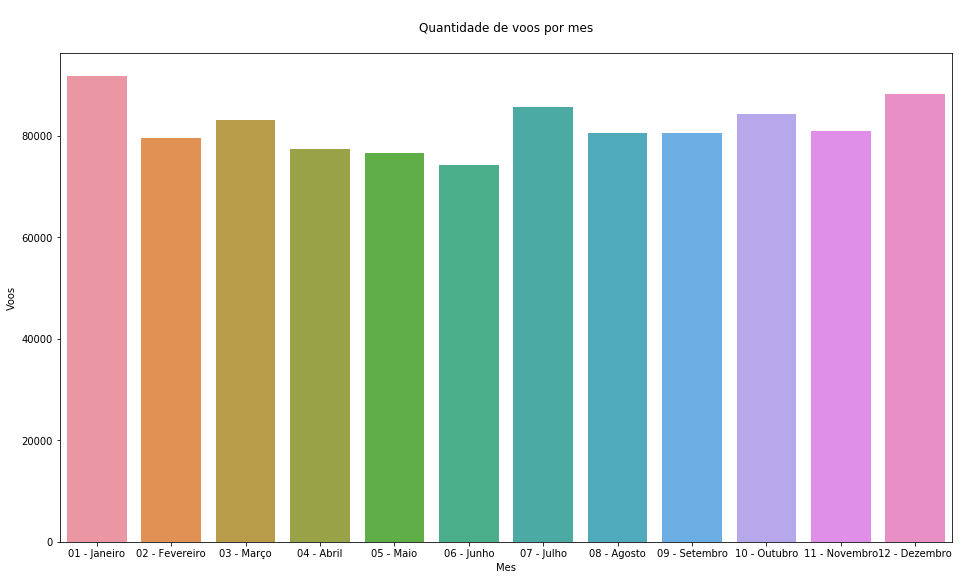

In [58]:
partida = data[['mes','dia']].groupby('mes').count().reset_index()

fig, ax = plt.subplots(figsize = (16, 9))

sns.barplot(x = 'mes', y = 'dia', data = partida, ax = ax)
ax.set_xlabel('Mes')
ax.set_ylabel('Voos')
ax.set_title('\nQuantidade de voos por mes\n');